### This code was developed by Gillian Cartwright, I (Jimena) only did minor modifications

In [1]:
script = False

import numpy as np
import pandas as pd

import random
import os
from astropy.io import fits
from astropy.table import Table

import matplotlib.ticker as plticker
import matplotlib.pyplot as plt

if(script): 
    from tqdm import tqdm
else:
    from tqdm.notebook import tqdm


from astropy.visualization import make_lupton_rgb
plt.style.use('dark_background')

In [2]:
def make_plot_all(objects, title, data):
    #print(title)
    for i in range(len(objects)):
        if(i%6 == 0):
            plt.figure(figsize=(16,9))
            for j in range(6):
                if(i+j > len(objects)-1): break
                plt.subplot(1,6,j+1)
                #print(data['COADD_OBJECT_ID'][i+j])
                #new_title = 'Prob: {:.2f}'.format(data['Prob'][i+j])
                #plt.title(new_title)
                rgb = make_lupton_rgb(objects[i+j][2], objects[i+j][1], objects[i+j][0], Q=11., stretch=40.)
                plt.imshow(rgb, aspect='equal')
                plt.xticks([], [])
                plt.yticks([], []) 
            plt.show()

4000


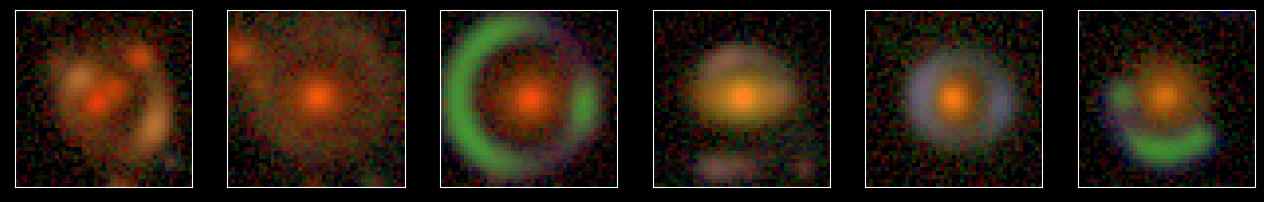

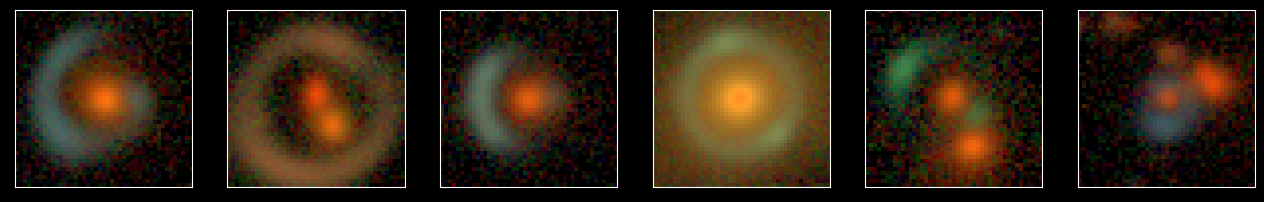

In [3]:
hdu_list = fits.open('simulation_file.fits')
print(len(hdu_list[1].data))

images_sim = hdu_list[1].data
images_sim = images_sim[:,0:3,:,:]
images_source = hdu_list[2].data
images_source = images_source[:,0:3,:,:]
images_lens = hdu_list[3].data
images_lens = images_lens[:,0:3,:,:]
data = pd.DataFrame(hdu_list[4].data)
hdu_list.close()

nred = 12
idx = random.sample(range(len(data)), nred)
make_plot_all(images_sim[idx], 'title', data.iloc[idx])

In [4]:
def plot_three(img_1, img_2, img_3, titles):
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))

    img1 = ax[0].imshow(img_1)
    plt.colorbar(img1, ax=ax[0])  
    ax[0].set_title(titles[0])
    ax[0].axis('off')


    img2 = ax[1].imshow(img_2)
    plt.colorbar(img2, ax=ax[1])
    ax[1].set_title(titles[1])
    ax[1].axis('off')

    img3 = ax[2].imshow(img_3)
    plt.colorbar(img3, ax=ax[2])
    ax[2].set_title(titles[2])
    ax[2].axis('off')

    plt.show()
    plt.close()

In [5]:
# Makes 3 plots per image: source simulation, lens cutout, complete simulation
def rgb_graphs(name, sim_i, sim_r, sim_g, cutout_i, cutout_r, cutout_g):
    loc = plticker.MultipleLocator(base=3.75)
    fig, ax = plt.subplots(figsize=(15, 4), ncols=3)

    sim_rgb = make_lupton_rgb(sim_i, sim_r, sim_g, Q=11., stretch=40.)
    
    ax[0].set_title('Source(s)')
    ax[0].axis('off')
    original = ax[0].imshow(sim_rgb, aspect='equal')

    cutout_rgb = make_lupton_rgb(cutout_i, cutout_r, cutout_g, Q=11., stretch=40.)
    ax[1].set_title('Lens')
    ax[1].axis('off')
    cutout = ax[1].imshow(cutout_rgb, aspect='equal')
            
    rgb = make_lupton_rgb(sim_i+cutout_i, sim_r+cutout_r, sim_g+cutout_g, Q=11., stretch=40.)
    ax[2].set_title('Complete Simulation')
    ax[2].axis('off')
    projection = ax[2].imshow(rgb, aspect='equal')
   
    plt.show()
    plt.close()

In [6]:
def source_mask(single_band_img):
    # turn 2d image into list
    pix_list = single_band_img.flatten(order='C')
    threshold = np.mean(pix_list) + 0.1 * np.std(pix_list)

    # iterate through pixels and change values to 0 or mask number
    for i, pix in enumerate(pix_list):
        if pix >= threshold:  # threshold value
            pix_list[i] = 1  # number pixels will be masked to
        else:
            pix_list[i] = 0

    # turn masked list back into 2d image
    masked = np.reshape(pix_list, (45, 45), order='C')
    return masked

In [7]:
def lens_and_background_mask(single_band_img, row):    
    # the radius for the lens is the object's flux radius:
    flux_radius = data.iloc[0, 8]  # i band flux radius
    radius = 2 * flux_radius  # a few extra pixels as a buffer

    # make a list of coordinates (not in arcsec)
    X2d, Y2d = np.meshgrid(np.arange(-22, 23), np.arange(-22, 23))
    coords = np.column_stack((Y2d.ravel(),X2d.ravel())).tolist()

    # make list of distances to center from coordinate list
    dist_from_center = []
    for i in range(len(coords)):
        distance = np.sqrt(coords[i][0] ** 2 + coords[i][1] ** 2)
        dist_from_center.append(distance)

    # turn 2d image into list
    pix_list = single_band_img.flatten(order='C')
    threshold = np.mean(pix_list) + 1.75 * np.std(pix_list)  # magnitude threshold
    
    # iterate through pixels and set corresponding values
    for i, pix in enumerate(pix_list):
        if pix > threshold and dist_from_center[i] < radius:  # lens = 2
            pix_list[i] = 2  # number pixels will be masked to

        elif pix > threshold and dist_from_center[i] >= radius:  # noise = 4
            pix_list[i] = 4  # number for bright background noise

        else:  # background = 0
            pix_list[i] = 0

    # return to 2d form
    masked = np.reshape(pix_list, (45, 45), order='C')

    return masked

In [8]:
def mask_image(coadd_id):
    # index data frame by coadd_id
    row = data[data['Y6_COADD_OBJECT_ID'] == coadd_id].index[0]

    # images_sim
    source_g, source_r, source_i = images_source[row][0], images_source[row][1], images_source[row][2]
    lens_g, lens_r, lens_i = images_lens[row][0], images_lens[row][1], images_lens[row][2]
    #rgb_graphs('name', source_i, source_r, source_g, lens_i, lens_r, lens_g)

    # apply masks to source and lens
    masked_source = source_mask(source_i)
    masked_lens = lens_and_background_mask(lens_i, row)
    
    # combine masks into one image
    all_masked = np.add(masked_source, masked_lens)
    
    # turn 2d image into list
    pix_list = all_masked.flatten(order='C')
    
    # iterate through pixels and change values to 0 or mask number
    for i, pix in enumerate(pix_list):
        if pix == 3:  # if lens and source overlap
            pix_list[i] = 2  # mask as lens
        elif pix == 5:  # if background noise and source overlap
            pix_list[i] = 4
            
        else:
            pix_list[i] = pix_list[i]

    # turn masked list back into 2d image
    masked = np.reshape(pix_list, (45, 45), order='C')

    # plot
    #plot_three(masked_source, masked_lens, masked, ['Source Mask',
    #                                                'Lens and Noise Masks',
    #                                                'All Masks'])
    return(masked_source, masked)

In [9]:
masked_source, masked_complete = mask_image(966802453)

In [10]:
numpix = 45
masks_source, masks_complete = np.zeros((1,numpix,numpix)), np.zeros((1,numpix,numpix))

with tqdm(total=len(data)) as pbar:
    for (index, row) in data.iterrows():
        masked_source, masked_complete = mask_image(row['Y6_COADD_OBJECT_ID'])
        masks_source = np.append(masks_source, [masked_source], axis = 0)
        masks_complete = np.append(masks_complete, [masked_source], axis = 0)
        pbar.update(1)
masks_source = np.delete(masks_source, 0, axis = 0)
masks_complete = np.delete(masks_complete, 0, axis = 0)

  0%|          | 0/4000 [00:00<?, ?it/s]

In [11]:
# Writes fit file
def write_fit_file(name, images, data):
    my_types = {'Y6_COADD_OBJECT_ID': int, 'TILENAME': str, 'HPIX_16384': int, 'HPIX_4096': int,
       'DNF_ZMEAN_SOF': float, 'RA': float, 'DEC': float, 'FLUX_RADIUS_G': float, 'FLUX_RADIUS_R': float,
       'FLUX_RADIUS_I': float, 'FLUX_RADIUS_Z': float, 'KRON_RADIUS': float, 'GAP_FLUX_G': float,
       'MOF_BDF_FLUX_G': float, 'MOF_PSF_FLUX_G': float, 'SOF_BDF_FLUX_G': float, 'SOF_PSF_FLUX_G': float,
       'MAG_AUTO_G': float, 'MAG_APER_4_G': float, 'MAG_APER_8_G': float, 'SOF_BDF_G_1': float,
       'Y3_COADD_OBJECT_ID': int, 'REFMAG': float, 'REFMAG_ERR': float, 'LUM': float, 'ZREDMAGIC': float,
       'ZREDMAGIC_E': float, 'CHISQ': float, 'Z_LENS': float, 'MAG_G': float, 'MAG_R': float, 'MAG_I': float, 'MAG_Z': float,
       'MAG_ERR_G': float, 'MAG_ERR_R': float, 'MAG_ERR_I': float, 'MAG_ERR_Z': float, 'ZG': float, 'ZR': float, 'ZI': float,
       'ZZ': float, 'SOF_BDF_G_2': float, 'IMAFLAGS_ISO_G': int, 'IMAFLAGS_ISO_R': int,
       'IMAFLAGS_ISO_I': int, 'IMAFLAGS_ISO_Z': int, 'EXT_COADD': int, 'FWHM_WMEAN_G': float,
       'FWHM_WMEAN_R': float, 'FWHM_WMEAN_I': float, 'FWHM_WMEAN_Z': float, 'SKYBRITE_WMEAN_G': float,
       'SKYBRITE_WMEAN_R': float, 'SKYBRITE_WMEAN_I': float, 'SKYBRITE_WMEAN_Z': float, 'Z1': float, 'LENSED_MAG': float,     
       'mag_1': float, 'ISOLATION': float, 'EINSTEIN_RADIUS': float, 'MAGNIFICATION': float, 'POSITION1': float}
    data = data.astype(my_types)
    
    sim_images, source_images, lens_images = images[0], images[1], images[2]
    
    primary = fits.PrimaryHDU()
    image1 = fits.ImageHDU(images[0], name="IMAGE")
    image2 = fits.ImageHDU(images[1], name="IMAGE")
    image3 = fits.ImageHDU(images[2], name="IMAGE")
    image4 = fits.ImageHDU(images[3], name="IMAGE")
    image5 = fits.ImageHDU(images[4], name="IMAGE")
    table_data = Table.from_pandas(data)
    table = fits.BinTableHDU(data = table_data)
    hdu_list = fits.HDUList([primary, image1, image2, image3, image4, image5, table])
    hdu_list.writeto(name + '.fits', overwrite=True)   
    hdu_list.close()

In [12]:
images = [images_sim, images_source, images_lens, masks_source, masks_complete]
name = 'labeled_file'
write_fit_file(name, images, data)